![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  bool 
 4   M_Camry4dr   10495 non-null  bool 
 5   M_CamryBase  10495 non-null  bool 
 6   M_CamryL     10495 non-null  bool 
 7   M_CamryLE    10495 non-null  bool 
 8   M_CamrySE    10495 non-null  bool 
 9   M_CamryXLE   10495 non-null  bool 
dtypes: bool(7), int64(3)
memory usage: 657.8 KB


In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,10495.0,14538.403716,3922.420961,5002.0,11999.0,15000.0,16999.0,32444.0
Year,10495.0,2013.553883,3.116585,1998.0,2012.0,2014.0,2016.0,2018.0
Mileage,10495.0,52509.430395,36791.736601,5.0,26461.0,41680.0,71355.5,232658.0


In [5]:
from ydata_profiling import ProfileReport
carListings_profile = ProfileReport(data, title="Reporte carListings", explorative=True)

# Export  report to  HTML 
carListings_profile.to_file("carListings-data-report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [3]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
def encode_bool(X):
    X_encoded = X.copy()
    X_encoded = X_encoded.applymap(lambda x: int(x) if isinstance(x, bool) else x)
    return X_encoded

In [11]:
X_train_enc = encode_bool(X_train)
X_test_enc = encode_bool(X_test)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [17]:
# Celda 1
# Para este punto se adapta el código del S1LAB1_construccción_calibracion_arboles visto durante la semana 1 para solucionar el problema de regresión
import numpy as np

# Definición funciones impureza
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return ((y - y.mean()) ** 2).mean()
    
def mae(y):
    if y.shape[0] == 0:
        return 0
    return (y - y.median()).abs().mean()

# Definición de la función impurity_reduction para calcular la mejora de una variable predictora j dado el punto de corte k
def impurity_reduction(X_col, y, split, criterio="mse"):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    if criterio == "mse":
        impurity = mse
    elif criterio == "mae":
        impurity = mae
    else:
        raise ValueError("Criterio invalido, debe ser 'mse' o 'mae'")

    imp_y = impurity(y)
    imp_l = impurity(y_l)
    imp_r = impurity(y_r)
    
    imp_red_ = imp_y - (n_l / (n_l + n_r) * imp_l + n_r / (n_l + n_r) * imp_r)
    return imp_red_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10, criterio="mse"):   
    features = range(X.shape[1])
    best_split = [0, 0, -np.inf]  # j, split, gain
    
    # Para todas las variables 
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # Para cada partición
        for split in splits:
            gain = impurity_reduction(X.iloc[:, j], y, split, criterio=criterio)        
            if gain > best_split[2]:
                best_split = [j, split, gain] 
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, criterio="mse" ):
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct,  criterio=criterio)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() if criterio == "mse" else y.median()
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    return tree

In [18]:
# Aplicación de la función tree_grow usando MSE
mse_tree = tree_grow(X_train_enc, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10, criterio = "mse")
mse_tree

{'y_pred': 14508.073389276064,
 'level': 0,
 'split': [0, 2014.0],
 'n_samples': 7031,
 'gain': 8706079.2690802,
 'sl': {'y_pred': 10234.929955947136,
  'level': 1,
  'split': [0, 2012.0],
  'n_samples': 2270,
  'gain': 4019659.1499605672,
  'sl': {'y_pred': 8737.28071379547,
   'level': 2,
   'split': [1, 97798.72727272728],
   'n_samples': 1457,
   'gain': 1109280.4742891928,
   'sl': {'y_pred': 9891.465256797583,
    'level': 3,
    'split': [0, 2008.0],
    'n_samples': 662,
    'gain': 902634.9592679311,
    'sl': {'y_pred': 8421.194871794873,
     'level': 4,
     'split': [0, 2006.0],
     'n_samples': 195,
     'gain': 336865.7958247354,
     'sl': {'y_pred': 7618.9701492537315,
      'level': 5,
      'split': [1, 51260.0],
      'n_samples': 67,
      'gain': 281288.4641247627,
      'sl': {'y_pred': 8754.416666666666,
       'level': 6,
       'split': [1, 39086.0],
       'n_samples': 12,
       'gain': 526056.166865079,
       'sl': {'y_pred': 9612.6,
        'level': 7,
 

In [20]:
# Aplicación de la función tree_grow usando MAE
mae_tree = tree_grow(X_train_enc, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10, criterio = "mae")
mae_tree

{'y_pred': 15000.0,
 'level': 0,
 'split': [0, 2012.0],
 'n_samples': 7031,
 'gain': 1077.1767885080355,
 'sl': {'y_pred': 8737.28071379547,
  'level': 1,
  'split': [1, 97798.72727272728],
  'n_samples': 1457,
  'gain': 1109280.4742891928,
  'sl': {'y_pred': 9891.465256797583,
   'level': 2,
   'split': [0, 2008.0],
   'n_samples': 662,
   'gain': 902634.9592679311,
   'sl': {'y_pred': 8421.194871794873,
    'level': 3,
    'split': [0, 2006.0],
    'n_samples': 195,
    'gain': 336865.7958247354,
    'sl': {'y_pred': 7618.9701492537315,
     'level': 4,
     'split': [1, 51260.0],
     'n_samples': 67,
     'gain': 281288.4641247627,
     'sl': {'y_pred': 8754.416666666666,
      'level': 5,
      'split': [1, 39086.0],
      'n_samples': 12,
      'gain': 526056.166865079,
      'sl': {'y_pred': 9612.6,
       'level': 6,
       'split': [2, 0.18181818181818166],
       'n_samples': 5,
       'gain': 507387.8400000001,
       'sl': {'y_pred': 9031.0,
        'level': 7,
        'spl

In [14]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree):
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [19]:
# Evaluación Arbol Manual usando MSE como criterio reducción de impureza
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

mse_tree_pred = tree_predict(X_test_enc, mse_tree)

mse_tree_rmse = np.sqrt(mean_squared_error(y_test, mse_tree_pred ))
mse_tree_mae = median_absolute_error(y_test, mse_tree_pred)

# Resultados
print("El RMSE del arbol manual usando mse como criterio para la reduccion de impureza es:", f"{mse_tree_rmse:.3f}")
print("El MAE del arbol manual usando mse como criterio para la reduccion de impureza es:", f"{mse_tree_mae:.3f}")

El RMSE del arbol manual usando mse como criterio para la reduccion de impureza es: 1692.100
El MAE del arbol manual usando mse como criterio para la reduccion de impureza es: 955.601


In [21]:
# Evaluación Arbol Manual usando MAE como criterio reducción de impureza
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

mae_tree_pred = tree_predict(X_test_enc, mae_tree)

mae_tree_rmse = np.sqrt(mean_squared_error(y_test, mae_tree_pred ))
mae_tree_mae = median_absolute_error(y_test, mae_tree_pred)

# Resultados
print("El RMSE del arbol manual usando mae como criterio para la reduccion de impureza es:", f"{mae_tree_rmse:.3f}")
print("El MAE del arbol manual usando mae como criterio para la reduccion de impureza es:", f"{mae_tree_mae:.3f}")

El RMSE del arbol manual usando mae como criterio para la reduccion de impureza es: 1670.921
El MAE del arbol manual usando mae como criterio para la reduccion de impureza es: 960.267


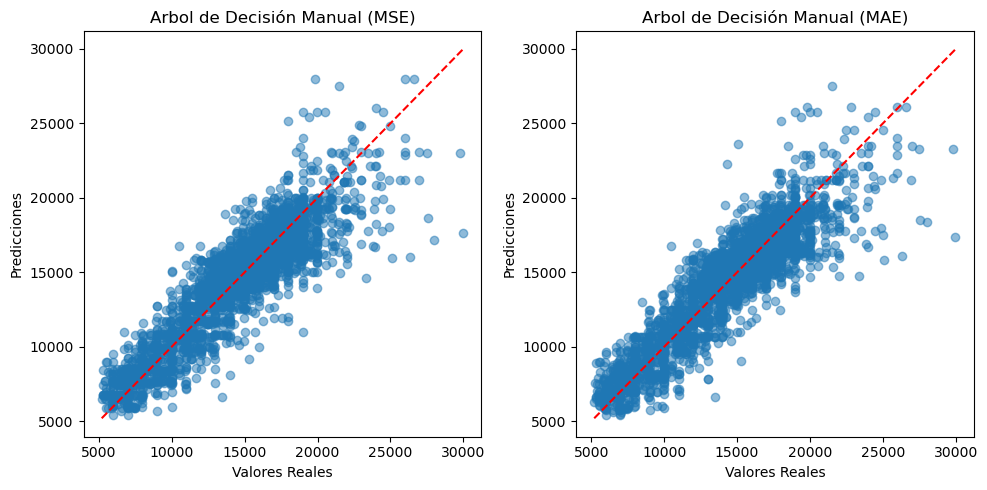

In [23]:
# Comparación gráfica de resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Predicciones Arbol MSE
plt.subplot(1, 2, 1)
plt.scatter(y_test, mse_tree_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Arbol de Decisión Manual (MSE)")

# Predicciones Arbol MAE
plt.subplot(1, 2, 2)
plt.scatter(y_test, mae_tree_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Arbol de Decisión Manual (MAE)")

plt.tight_layout()
plt.show()

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3


### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 5


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [ ]:
# Celda 8
